<a href="https://colab.research.google.com/github/kimdonggyufive/OpenReposit/blob/main/3_buston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Boston housing - linear regression

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import keras
keras.__version__

'2.7.0'

In [3]:
import numpy as np
import tensorflow as tf

np.random.seed(777)
tf.random.set_seed(777)

In [4]:
from tensorflow.keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets)=boston_housing.load_data()

In [5]:
train_data.shape

(404, 13)

In [6]:
test_data.shape

(102, 13)

In [7]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

# Data preparation

In [8]:
mean=train_data.mean(axis=0)
train_data-=mean
std=train_data.std(axis=0)
train_data/=std

test_data-=mean
test_data/=std

# Modeling

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [10]:
def build_model():
  model=Sequential()
  model.add(Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
  model.add(Dense(64,activation='relu'))
  #하나의 층을 통과한다.
  model.add(Dense(1))
  #optimizer는 adam 평가 모델은 mae
  model.compile(optimizer='adam',loss='mse',metrics=['mae'])
  return model

# Kfold cross validation

In [11]:
#4개의 파트로 나누어서 
k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

import time
for i in range(k):
    print('처리중인 폴드 #', i, time.strftime('%c',time.localtime(time.time())))
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history=model.fit(partial_train_data, partial_train_targets,
        epochs=num_epochs, batch_size=64, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets)
    all_scores.append(val_mae)

처리중인 폴드 # 0 Wed Dec 15 01:18:40 2021
4/4 [==============================] - 0s 5ms/step - loss: 9.3130 - mae: 2.1421
처리중인 폴드 # 1 Wed Dec 15 01:18:43 2021
4/4 [==============================] - 0s 3ms/step - loss: 13.1975 - mae: 2.8165
처리중인 폴드 # 2 Wed Dec 15 01:18:46 2021
4/4 [==============================] - 0s 3ms/step - loss: 16.0145 - mae: 2.6469
처리중인 폴드 # 3 Wed Dec 15 01:18:50 2021
4/4 [==============================] - 0s 4ms/step - loss: 13.4608 - mae: 2.6327


In [12]:
all_scores

[2.1420555114746094,
 2.8164761066436768,
 2.6469333171844482,
 2.6326746940612793]

In [13]:
np.mean(all_scores)

2.5595349073410034

# Epoch을 늘려서 Train

In [14]:
from keras import backend as K

K.clear_session()

In [51]:
k=4
num_epochs = 500
all_mae_histories=[]

#import time
for i in range(k):
  print('처리중인 폴드 #', i, time.strftime('%c',time.localtime(time.time())))
  # 검증 데이터 준비: k번째 분할
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  # 훈련 데이터 준비: 다른 분할 전체
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
      axis=0)

  model = build_model()
  #아래 평가 데이터들은 history에 들어 있다.
  history=model.fit(partial_train_data, partial_train_targets,
      validation_data=(val_data, val_targets),
      epochs=num_epochs, batch_size=64, verbose=0)
  val_mse, val_mae = model.evaluate(val_data,val_targets)

  mae_history=history.history['val_mae']
  all_mae_histories.append(mae_history)

처리중인 폴드 # 0 Wed Dec 15 02:07:38 2021
4/4 [==============================] - 0s 3ms/step - loss: 8.1008 - mae: 2.1269
처리중인 폴드 # 1 Wed Dec 15 02:08:20 2021
4/4 [==============================] - 0s 3ms/step - loss: 8.9938 - mae: 2.3128
처리중인 폴드 # 2 Wed Dec 15 02:08:35 2021
4/4 [==============================] - 0s 3ms/step - loss: 12.0517 - mae: 2.3992
처리중인 폴드 # 3 Wed Dec 15 02:08:55 2021
4/4 [==============================] - 0s 3ms/step - loss: 10.9511 - mae: 2.3044


In [16]:
#history.epoch, history.history.keys
history.history.keys()


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [18]:
#각 나눈 데이터들의 평균들을 구하는데 나눈 데이터 수는
len(all_mae_histories[0]),len(all_mae_histories[1]),len(all_mae_histories[2]),len(all_mae_histories[3])

(500, 500, 500, 500)

In [19]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [20]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
#모든 계산된 평균들이 저장된다. 각4 번 반복의 평균 값들이 들어있다.
average_mae_history

[21.93287706375122,
 21.437023639678955,
 20.90539026260376,
 20.323078632354736,
 19.658235549926758,
 18.887956142425537,
 18.00573992729187,
 17.000810146331787,
 15.858413219451904,
 14.588934898376465,
 13.224184513092041,
 11.781488418579102,
 10.34542429447174,
 9.073756456375122,
 7.992379188537598,
 7.108150005340576,
 6.451194882392883,
 5.959416031837463,
 5.592790305614471,
 5.298391938209534,
 5.034512579441071,
 4.79327529668808,
 4.56681615114212,
 4.375003516674042,
 4.214923560619354,
 4.070713758468628,
 3.9394625425338745,
 3.8367998600006104,
 3.74614280462265,
 3.671952962875366,
 3.601811468601227,
 3.5463184118270874,
 3.494559407234192,
 3.447564125061035,
 3.401675045490265,
 3.3603832721710205,
 3.3233401775360107,
 3.289446175098419,
 3.260637044906616,
 3.2312103509902954,
 3.209916889667511,
 3.180342972278595,
 3.165925621986389,
 3.1423307061195374,
 3.120754897594452,
 3.0925099849700928,
 3.080615282058716,
 3.0587908029556274,
 3.0345040559768677,
 3.0

In [21]:
model.evaluate(test_data,test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 20.5441 - mae: 2.9145


[20.54410743713379, 2.914531707763672]

# 시각화

In [22]:
import matplotlib.pyplot as plt

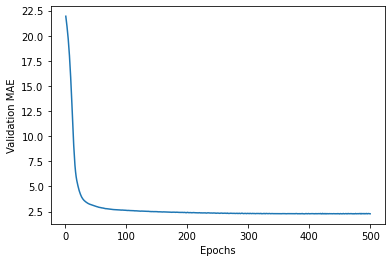

In [30]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

SyntaxError: ignored

In [35]:
def smooth_curve(points, factor = 0.9):
  smoothed_points = [100]
  for point in points:
    #smoothed_points가 비어있지 않다면
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor+point *(1.-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [40]:
#경사가 너무 심한 앞쪽에 데이터는 삭제한다.
smooth_mae_history=smooth_curve(average_mae_history[10:])

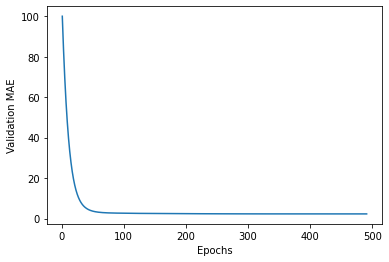

In [41]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [47]:
model=build_model()
model.fit(train_data, train_targets,
          epochs=200, batch_size=8, verbose=1)

Epoch 1/200
51/51 [==============================] - 1s 3ms/step - loss: 502.0403 - mae: 20.3832
Epoch 2/200
51/51 [==============================] - 0s 3ms/step - loss: 191.0445 - mae: 11.2828
Epoch 3/200
51/51 [==============================] - 0s 3ms/step - loss: 51.3462 - mae: 5.3141
Epoch 4/200
51/51 [==============================] - 0s 3ms/step - loss: 32.0408 - mae: 4.0338
Epoch 5/200
51/51 [==============================] - 0s 3ms/step - loss: 24.8384 - mae: 3.4433
Epoch 6/200
51/51 [==============================] - 0s 3ms/step - loss: 20.9612 - mae: 3.2072
Epoch 7/200
51/51 [==============================] - 0s 3ms/step - loss: 18.2481 - mae: 3.0026
Epoch 8/200
51/51 [==============================] - 0s 3ms/step - loss: 16.4585 - mae: 2.8002
Epoch 9/200
51/51 [==============================] - 0s 3ms/step - loss: 15.0421 - mae: 2.7526
Epoch 10/200
51/51 [==============================] - 0s 3ms/step - loss: 14.1368 - mae: 2.6335
Epoch 11/200
51/51 [=========================

In [48]:
test_mse_score, test_mae_score=model.evaluate(test_data,test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 13.0397 - mae: 2.5627


2.562708616256714